# Homework 5 - Ridge, Lasso, Logistic Regressio, and Q-learning
## CSCI 4622 - Fall 2022

***
**Name**: $Ryan Vogel$
***

This assignment is due on Canvas by **11.59 PM on Friday, Nov 11th**.
Submit only this Jupyter notebook to Canvas. Do not compress it using tar, rar, zip, etc.
The last bonus problem will require additional files to be submitted. We'll explain its submission format later.

Your solutions to analysis questions should be done in Markdown directly below the associated question.
Remember that you are encouraged to discuss the problems with your classmates and instructors,
but **you must write all code and solutions on your own**, and list any people or sources consulted.

In [11]:
#!pip install -r requirements.txt #uncomment to install all required packages
import numpy as np
import matplotlib.pyplot as plt
import tests
import data

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'
You should consider upgrading via the '/opt/homebrew/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.


# Problem 1: Ridge and Lasso (30pts)

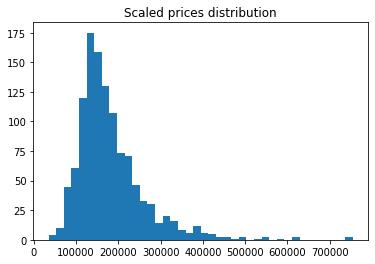

In [3]:
house_prices = data.HousePrices()
plt.hist(house_prices.y_train, bins=40)
plt.title("Scaled prices distribution")
plt.show()

We have seen that Ridge regression adds a regularization term to the least square using the L2 norm.
Ridge regression is part of scikit-learn package ([read more](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)), but we will be building our own implementation.
You can test your implementation against scikit's.

The objective of Ridge regression is to minimize:

\begin{align}
\frac{1}{N}\sum_{i=1}^{N} ||y_i-\mathbf{w}^T \mathbf{x_i}-\mathbf{b}||^2 + \alpha||\mathbf{w}||^2
\end{align}

where $\mathbf{w}$ denotes the coefficients vector for the linear regression model,
$\mathbf{b}$ the intercept, $\alpha$ the trade-off regularization parameter, and $N$ the number of samples.

Luckily for us, Ridge regression admits a closed form solution for $\mathbf w$ and $\mathbf{b}$.

Let $X$ be the $N\times d$ matrix whose rows are the training samples $(\mathbf{x_i})_{i\leq N}$ and $Y=(y_i)_{i\leq N}$ the target values.

First, we start by centering the features (columns of X) by subtracting the mean of the column to get centered matrix $\tilde{X}$. Then the solution for the minimization is (trust me):

\begin{align}
&\mathbf{w^*} = (\tilde{X}^T\tilde{X}+ \alpha I)^{-1}\tilde{X}^TY \\
&\mathbf{b^*} = \frac{1}{N} \sum_{i}^{i=N} (y_i - \mathbf{w^*}^T \mathbf{x_i})
\end{align}

Note that:
- The samples in $b^*$ are not centered.
- The predicted targets would be $\hat{y}_i = \mathbf{w^*}^T \mathbf{x_i}-\mathbf{b^*} $
- $\tilde{X}$ is only needed in the `fit` method when we compute $\mathbf{w^*}$ and $\mathbf{b^*}$

A common practice is to scale or normalize (usually normalize) the features before fitting the model. It allows a _fair_ treatment of different features.
You are allowed to use scikit's `StandardScaler` to do the normalization (yes, a thing called scaler is normalizing. Don't @ me, @ sklearn). Do not forget to run the same transformation on the test data before running the prediction.

**Q1.1[6 points]** Complete the `fit` and `evaluate` methods following the provided descriptions.

In [4]:
from sklearn.preprocessing import StandardScaler

class Ridge(object):

    def __init__(self, alpha, normalize=False):
        """
        :param alpha: regularization parameter
        :param normalize: boolean whether to normalize the features or not
        """

        self.alpha = alpha  # our tuning / regularization parameter
        self.coefficients = None  # our weights vector, w (in formulae above)
        self.intercept = None  # our intercept parameter, b (in formulae above)
        self.normalize = normalize  # boolean whether to normalize the features or not
        self.scaler = StandardScaler()  # method by which to normalize the features (depends on self.normalize)

    def fit(self, X, y):
        """
        Fit the ridge model, train it using the provided data
        Calculate the number of non-zero coefficients in the model weights and the norm using np.linalg.norm
        :param X: training features (num_samples, num_features)
        :param y: target values (num_samples)
        :return: tuple (number of non-zeros coefficients of w, norm of w)
        """
        num_nonzero_coefs, coef_norm = 0, 0
        # Workspace 1.1.a
        # TO DO: compute w and b and store them in self.coef_ and self.intercept
        # HINT: use self.scaler first, if and only if self.normalize is True
        # BEGIN 

        if self.normalize:
            scail = self.scaler.fit(X)
            X_norm = scail.transform(X)

            w = np.linalg.inv(X_norm.T.dot(X_norm) + self.alpha * np.identity(X_norm.shape[1]))
            w = w.dot(X_norm.T)
            w = w.dot(y)

            b = np.mean(y) - np.mean(X_norm, axis=0).dot(w)
        else:
            X_center = np.copy(X) - np.mean(X, axis=0)
            w = np.linalg.inv(X_center.T.dot(X_center) + self.alpha * np.identity(X_center.shape[1]))
            w = w.dot(X_center.T)
            w = w.dot(y)

            b = np.mean(y) - np.mean(X, axis=0).dot(w)
        
        # END
        self.coefficients = w
        self.intercept = b

        #count the number of non-zero coefficients
        num_nonzero_coefs = np.count_nonzero(self.coefficients)
        coef_norm = np.linalg.norm(self.coefficients)

        return num_nonzero_coefs, coef_norm

    def evaluate(self, X, y):
        """
        Compute Root mean square error (RMSE) between the predicted values and the actual values of the test data
        :param X: instances array of shape (num_samples, num_features)
        :param y: the true targets, of shape (num_samples)
        :return: RMSE
        """

        # Workspace 1.1.b
        # TO DO: predict based on the test features and return the root mean squared error
        # BEGIN 

        y_pred = self.coefficients.dot(X.T) - self.intercept
        rmse = np.sqrt(np.mean((y - y_pred)**2))
                # END
        root_mean_squared_error = rmse

        return root_mean_squared_error

In [5]:
# Tests cells, do not remove
# Should run without errors
tests.test_ridge_coef(Ridge, normalize=False)
tests.test_ridge_coef(Ridge, normalize=True)
tests.test_ridge_intercept(Ridge, normalize=True)
tests.test_ridge_intercept(Ridge, normalize=False)

Question 1.1.a: [PASS]
Question 1.1.a: [PASS]
Question 1.1.b: [PASS]
Question 1.1.b: [PASS]


- 1.2 **[6 points]** Produce 3 plots as a function of $\log_{10}(\alpha)$ (logarithmic scale) that compare normalized versus non-normalized Ridge:
    - The number of non-zero coefficients of $\mathbf w$
    - The norm of $\mathbf w$
    - The test RMSE (Root Mean Squared Error)

Use the values of $\alpha$ provided in the cell. What is the best `alpha` for each version of the two models?

To produce multiple plots in the same figure, see the examples [here](https://matplotlib.org/devdocs/gallery/subplots_axes_and_figures/subplots_demo.html)

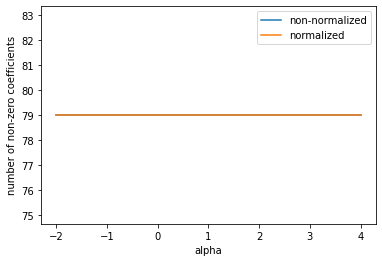

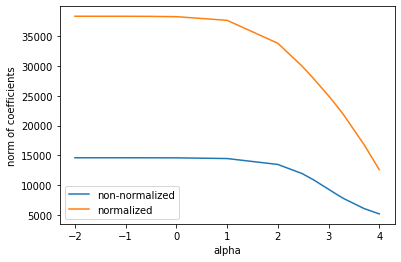

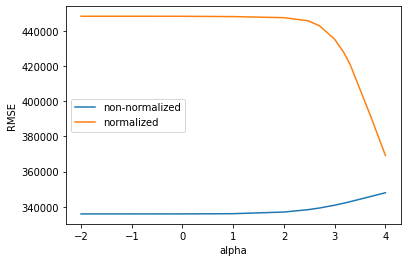

In [6]:
alphas = [0.01, 0.05, 0.1, 0.2, 0.3, 1.0, 10.0, 100.0, 300.0, 500.0, 1e3, 1.5e3, 2e3, 5e3, 1e4]
# Workspace 1.2
# BEGIN 
numNonzeroCoefs_n = []
numNonzeroCoefs = []
Norm = []
Norm_n = []
rsme = []
rsme_n = []
for A in alphas:
    ridge = Ridge(A)
    ridge_n = Ridge(A, normalize=True)
    ridge.fit(house_prices.X_train, house_prices.y_train)
    ridge_n.fit(house_prices.X_train, house_prices.y_train)

    numNonzeroCoefs_n.append(ridge_n.fit(house_prices.X_train, house_prices.y_train)[0])
    numNonzeroCoefs.append(ridge.fit(house_prices.X_train, house_prices.y_train)[0])
    Norm_n.append(ridge_n.fit(house_prices.X_train, house_prices.y_train)[1])
    Norm.append(ridge.fit(house_prices.X_train, house_prices.y_train)[1])
    rsme_n.append(ridge_n.evaluate(house_prices.X_test, house_prices.y_test))
    rsme.append(ridge.evaluate(house_prices.X_test, house_prices.y_test))
    

plt.plot(np.log10(alphas), numNonzeroCoefs, label='non-normalized')
plt.plot(np.log10(alphas), numNonzeroCoefs_n, label='normalized')
plt.xlabel('alpha')
plt.ylabel('number of non-zero coefficients')
plt.legend()
plt.show()


plt.plot(np.log10(alphas), Norm, label='non-normalized')
plt.plot(np.log10(alphas), Norm_n, label='normalized')
plt.xlabel('alpha')
plt.ylabel('norm of coefficients')
plt.legend()
plt.show()


plt.plot(np.log10(alphas), rsme, label='non-normalized')
plt.plot(np.log10(alphas), rsme_n, label='normalized')
plt.xlabel('alpha')
plt.ylabel('RMSE')
plt.legend()
plt.show()
# END


Based on the results from previous questions, you should have noticed that the interpretation of Ridge regression is not an easy task.
One way to solve that is to use a regularization that adds _sparsity_ to $\mathbf w$ and excludes less important features.
That's what Lasso regression is about.

Lasso uses $l_1$ norm in the regularization term and minimizes:
\begin{align}
\frac{1}{2N}\sum_i ||y_i-\mathbf{w}^t x_i -b||^2 + \alpha||\mathbf{w}||_1
\end{align}

It is part of scikit package ([more details](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html))
and you're free to compare your implementation to scikit's.

- 1.3 **[6 points]** Complete the LassoRegression class by using scikit's Lasso in `self.model`. Save its parameters in `coefficients` and `intercept` (You're allowed to use inheritance for a more concise code, as long as the class has `coefficients` and `intercept` attributes.)

In [7]:
from sklearn.linear_model import Lasso


class LassoRegression(object):
    def __init__(self, alpha, normalize=False):
        """
        :param alpha: regularization parameter
        :param normalize: boolean whether to normalize the features or not
        """
        self.model = Lasso(alpha=alpha)
        self.coefficients = None  # our weights vector, w (in formulae above)
        self.intercept = None  # our intercept parameter, b (in formulae above)
        self.normalize = normalize  # boolean whether to normalize the features or not
        self.scaler = StandardScaler()  # method by which to normalize the features (depends on self.normalize)

    def fit(self, X, y):
        """
        Fit the lasso model, train it using the provided data
        Calculate the number of non-zero coefficients in the model weights and the norm using np.linalg.norm
        :param X: training features (num_samples, num_features)
        :param y: target values (num_samples)
        :return: tuple (number of non-zeros coefficients of w: scalar, norm of w: scalar)
        """

        num_nonzero_coefs, coef_norm = 0, 0
        # Workspace 1.3.a
        # TO DO: compute w and b and store then in self.coef_ and self.intercept
        # TO DO: call lasso_path on the centered features to compute self.coef_
        # HINT: use self.scaler first, if and only if self.normalize is True
        # BEGIN 
        if self.normalize:
            scale = self.scaler.fit(X)
            X_norm = scale.transform(X)
            self.model.fit(X_norm, y)
            self.coefficients = self.model.coef_
            self.intercept = self.model.intercept_
        else:
            X_center = np.copy(X) - np.mean(X, axis=0)
            self.model.fit(X, y)
            self.coefficients = self.model.coef_
            self.intercept = np.mean(y) - np.mean(self.coefficients.dot(X.T))

        num_nonzero_coefs = np.count_nonzero(self.coefficients)
        coef_norm = np.linalg.norm(self.coefficients)
        # END





        return num_nonzero_coefs, coef_norm

    def evaluate(self, X, y):
        """
        Compute Root mean square error (RMSE) between the predicted values and the actual values  of the test data
        :param X: features array, shape (num_samples, num_features)
        :param y: true targets, shape (num_samples)
        :return: RMSE
        """
        root_mean_squared_error = 0
        # Workspace 1.3.b
        # TO DO: predict based on the test features and return the mean_squared_error
        # BEGIN 
        if self.normalize:
            X_norm = self.scaler.transform(X)
            y_pred = self.model.predict(X_norm)
        else:
            y_pred = self.model.predict(X)
        rmse = np.sqrt(np.mean((y_pred - y)**2))

        root_mean_squared_error = rmse
        # END
        return root_mean_squared_error

In [8]:
# Tests cell, do not remove
# Test non-normalized Lasso
tests.test_lasso_coef(LassoRegression, normalize=True)
tests.test_lasso_coef(LassoRegression, normalize=False)
tests.test_lasso_intercept(LassoRegression, normalize=True)
tests.test_lasso_intercept(LassoRegression, normalize=False)

Question 1.3.a: [PASS]
Question 1.3.a: [PASS]
Question 1.3.b: [PASS]
Question 1.3.b: [PASS]


- 1.4 **[6 points]** Produce 3 plots as a function of $\log_{10}(\alpha)$ (logarithmic scale) that compare normalized versus non-normalized Lasso:
    - The number of non-zero coefficients of $\mathbf w$
    - The norm of $\mathbf w$
    - The test RMSE (Root Mean Squared Error)

Use the values of $\alpha$ provided in the cell. What is the best `alpha` for each version of the two models?

Can you get all coefficients of $\mathbf w$ to 0 for the non-normalized Lasso?

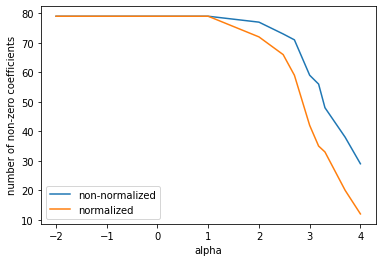

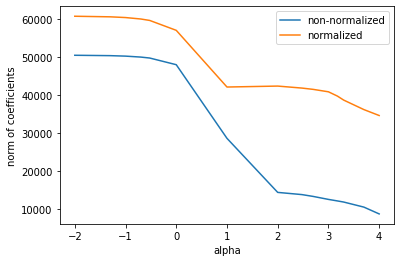

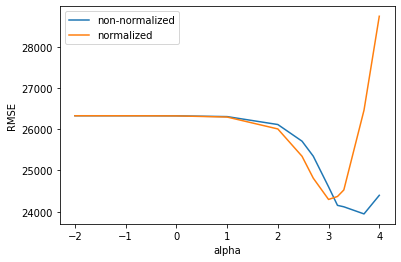

In [9]:
alphas = [0.01, 0.05, 0.1, 0.2, 0.3, 1.0, 10.0, 100.0, 300.0, 500.0, 1e3, 1.5e3, 2e3, 5e3, 1e4]
# Workspace 1.4
# BEGIN 
numNonzeroCoefs = []
numNonzeroCoefs_n = []
Norm = []
Norm_n = []
rsme = []
rsme_n = []

for A in alphas:
    lasso = LassoRegression(alpha=A)
    lasso_n = LassoRegression(alpha=A, normalize=True)
    lasso.fit(house_prices.X_train, house_prices.y_train)
    lasso_n.fit(house_prices.X_train, house_prices.y_train)

    numNonzeroCoefs_n.append(lasso_n.fit(house_prices.X_train, house_prices.y_train)[0])
    numNonzeroCoefs.append(lasso.fit(house_prices.X_train, house_prices.y_train)[0])
    Norm_n.append(lasso_n.fit(house_prices.X_train, house_prices.y_train)[1])
    Norm.append(lasso.fit(house_prices.X_train, house_prices.y_train)[1])
    rsme_n.append(lasso_n.evaluate(house_prices.X_test, house_prices.y_test))
    rsme.append(lasso.evaluate(house_prices.X_test, house_prices.y_test))

plt.plot(np.log10(alphas), numNonzeroCoefs, label='non-normalized')
plt.plot(np.log10(alphas), numNonzeroCoefs_n, label='normalized')
plt.xlabel('alpha')
plt.ylabel('number of non-zero coefficients')
plt.legend()
plt.show()

plt.plot(np.log10(alphas), Norm, label='non-normalized')
plt.plot(np.log10(alphas), Norm_n, label='normalized')
plt.xlabel('alpha')
plt.ylabel('norm of coefficients')
plt.legend()
plt.show()

plt.plot(np.log10(alphas), rsme, label='non-normalized')
plt.plot(np.log10(alphas), rsme_n, label='normalized')
plt.xlabel('alpha')
plt.ylabel('RMSE')
plt.legend()
plt.show()
# END

% BEGIN

The best alpha is 1E3 for normalized ridge and 1.5E3 for non-normalized ridge. 

We can never get all the coefficients of w to 0 for non-normalized Lasso.  becuase this model will have no data.  

% END

- 1.5 **[6 points]** (Write-up) Compare the two algorithms on the house prices dataset: compare the number of non-zero coordinates of Ridge vs Lasso and their RMSE on each dataset. Which type of regression is better? When does normalization improve the RMSE?

% BEGIN

The sumber of nonzero coeficants stays constant at 79 for ridge, but for lasso decreases to 11 non-zero coefficients for normalization, and 31 for non-normalization.  The RMSE for ridge decreases to 380000 for normalization, and starts around 340000 for non-normalization.  The RMSE for lasso for both normalization and non-normalization has its lowest rsme between 24000 and 25000.  The lasso is better for this dataset because it has a lower RMSE.  

***
# Problem 2: Logistic Regression for Binary Classification (40 points + 8)

The second part of this assignment will be dealing with Logistic Regression.
While the name "regression" suggests otherwise, Logistic Regression is actually used for classification.
It's a regression problem because the targets are the continuous likelihoods of the outcomes.

Our dataset is the binary digits dataset. The class label is `0` if the digit is even and 0 otherwise.

In [10]:
binary_digits = data.BinaryDigits()

Using the same notations from Problem 1 (this time with discrete targets $y_i$ in {0, 1}), _Logistic Regression_ is about minimizing the **N**egative **L**og **L**ikelihood objective defined as:
\begin{align}
\textrm{NLL}(\mathbf{w}) = -\frac{1}{N}\sum_{i=1}^N \left[y_i \log \sigma(\mathbf{w}^T{\mathbf{x_i}}) + (1-y_i)\log(1 - \sigma(\mathbf{w}^T\mathbf{x_i}))\right]
\end{align}

You might be wondering: where is the intercept?
We're including the intercept in $(\mathbf x_i)_i$ since we'll be adding a constant feature $\mathbf x_{i,0} = 1$ to all samples $(\mathbf x_i)_i$.
We will call it the zero-th column and the intercept will be $\mathbf{w}_0$.
This zero-th column will be appended to the training samples in `fit` method and the test samples in `predict` method. $\sigma$ is the sigmoid function seen in class.

**Q2.1[5pts]** What is the derivative of the **NLL** w.r.t $\mathbf{w}$ is?


% BEGIN

The derivative of the NLL w.r.t w is
$$
\frac{\partial \textrm{NLL}(\mathbf{w})}{\partial \mathbf{w_j}} = \frac{1}{N}\sum_{i=1}^N \left[\frac{y_i}{\sigma(\mathbf{w}^T{\mathbf{x_i}})} + \frac{1-y_i}{1 - \sigma(\mathbf{w}^T\mathbf{x_i})}\frac{\partial \sigma(\mathbf{w}^T{\mathbf{x_i}})}{\partial \mathbf{w_j}}\right]\\
= \frac{1}{N}\sum_{i=1}^N \left[\frac{y_i}{\sigma(\mathbf{w}^T{\mathbf{x_i}})} + \frac{1-y_i}{1 - \sigma(\mathbf{w}^T\mathbf{x_i})}\sigma(\mathbf{w}^T{\mathbf{x_i}})(1-\sigma(\mathbf{w}^T{\mathbf{x_i}}))\mathbf{x_{i,j}}\right]
$$

% END

**Q2.2[5pts]** Complete the `sigmoid` function to return the sigmoid values $\sigma(\mathbf{w}^T{\mathbf{x_i}})$ given features array. You have to truncate the score $\mathbf{w}^T{\mathbf{x_i}}$ to the interval $[-25, 25]$ to avoid overflow of `np.exp`

**Q2.3[5pts]** Finish the `compute_gradient` function to return the derivative of the cost w.r.t. the weights

**Q2.4[5pts]** Finish the `batch_update` function so that it performs batch gradient descent using the provided batch data

**Q2.5[5pts]** Finish the `fit` function so that it performs several training epochs and returns the Recall score on the validation data at the end of each epoch. Initialize $\mathbf{w}$ so that $\mathbf{w}_j = \frac{1}{d}$

**Q2.6[2pts]** Finish the `predict` method to return the predicted labels (either 0 or 1)

In [31]:
from sklearn.metrics import recall_score

class LogisticRegression:

    def __init__(self, eta=0.1, alpha=0):
        """
        Create a logistic regression classifier
        :param eta: Learning rate
        :param alpha: We will use this parameter later (IN BONUS)
        """

        self.w = None  # uninitialized w
        self.eta = eta  # learning rate
        self.initialized = False # flag used to initialize w only once, it allows calling fit multiple times
        self.alpha = alpha  # regularization / penalty term (USED IN BONUS)

    def sigmoid(self, x, threshold=25.0):
        """

        :param x: features array of shape (num_samples, num_features + 1) (zero-th column appended)
        :param threshold: the truncating threshold for np.exp, default to 25.0
        :return: sigmoid values , of shape (num_samples,)
        """
        # Workspace 2.2
        # TO DO: Complete this function to return the output of applying the sigmoid function to the score
        # BEGIN 
        s = x.dot(self.w)
        for i in range(len(s)):
            if s[i] > threshold:
                s[i] = threshold
            elif s[i] < -threshold:
                s[i] = -threshold

        sigmoid = 1 / (1 + np.exp(-s))

        return sigmoid


        # END

    def compute_gradient(self, x, y):
        """
        Return the derivative of the cost w.r.t to the weights. Don't forget to average by batch_size
        :param x:  Feature vector, shape (batch_size, num_features +1), with zero-th column appended
        :param y: real binary class label, shape (batch_size)
        :return: gradient of shape (num_features + 1,)
        """

        # Workspace 2.3
        # TO DO: Finish this function to compute the gradient
        gradient = np.zeros((x.shape[1], ))
        # BEGIN 

        sig = self.sigmoid(x)

        for j in range(x.shape[1]):
            for i in range(x.shape[0]):
                gradient[j] += (y[i]/sig[i] - (1-y[i])/(1-sig[i])) * x[i][j]
        gradient = gradient/x.shape[0]
        
        
        # END
        return gradient

    def batch_update(self, batch_x, batch_y):
        """
        Single self.w update using the batch.
        :param batch_x: array of features (includes the constant feature at column 0), of shape (batch_size, num_features + 1)
        :param batch_y: array of target values, shape (batch_size,)
        :return: nothing
        """

        # Workspace 2.4
        # BEGIN 
        g = self.compute_gradient(batch_x, batch_y)
        self.w += self.eta*self.compute_gradient(batch_x, batch_y)
        # END

    def fit(self, X, y, epochs=1, batch_size=1, validation_X=None, validation_y=None):
        """
        train the LogisticRegression
        :param X: training features, shape (num_samples, num_features)
        :param y: training labels, shape (num_samples,)
        :param epochs: number of epochs, integer
        :param batch_size: size of batch for gradient update, 1 for SGD
        :param validation_X: validation rows, should default to training data if not provided
        :param validation_y: validation labels
        :return: recall score at the end of each epoch on validation data
        """

        if validation_X is None:
            validation_X, validation_y = X, y
        metrics = []
        # Workspace  2.5
        # TO DO: Process X to append the zero-th constant column and call self.optimize
        # TO DO: Compute average recall on the validation data at the end of each epoch
        # HINT: make sure to initialize w
        # BEGIN 
        
        #first initialize W with each value 1/d
        self.w = np.ones(X.shape[1]+1,)/X.shape[1]

        #apped X for the intercept
        X = np.append(np.ones((X.shape[0],1)), X, axis=1)

        #run the optimization
        for e in range(epochs):
            self.optimize(X, y, batch_size)
            y_pred = self.predict(validation_X)
            metrics.append(recall_score(validation_y, y_pred))


        # END
        return np.array(metrics)

    def predict(self, X):
        """
        :param X: features array, shape (num_samples, num_features) (without the constant column)
        :return: predicted binary label, shape (num_samples,)
        """
        # Workspace 2.6
        y_hat = np.zeros((X.shape[0],))
        X = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)  # We append zero-th column
        # BEGIN 
        y_hat = self.sigmoid(X)
        for i in range(len(y_hat)):
            if y_hat[i] >= 0.5:
                y_hat[i] = 1
            else:
                y_hat[i] = 0

        # END
        return y_hat

    def optimize(self, X, y, batch_size):
        """
        Perform one epoch batch gradient on shuffled data
        :param X: np.array of shape (num_samples, num_features +1), The training data with zero-th column appended
        :param y: target values of shape (num_samples,)
        :param batch_size: batch_size of the batch_update
        :return: None
        """
        indices = np.random.permutation(len(X))
        for i in range(0, X.shape[0], batch_size):
            batch_x = X[indices[i:i + batch_size]]
            batch_y = y[indices[i:i + batch_size]]
            self.batch_update(batch_x, batch_y)

After completing the class above, loop over the training data and perform batch training with `batch_size=1`(Stochastic Gradient Descent) for 50 epochs, and different values of eta ( see `etas`). Train your model and do the following:

**Q2.7[5pts]** Plot the recall trend for the different values of eta on the training data (epoch vs recall). (reset random seed for each loop to mitigate the randomness effect)

Use the values provided below

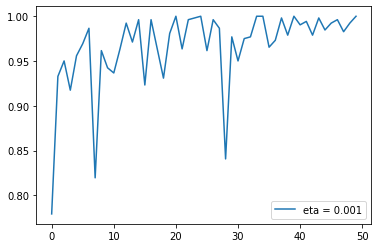

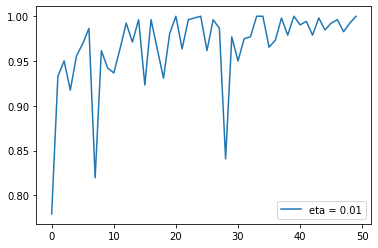

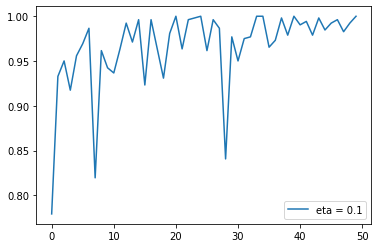

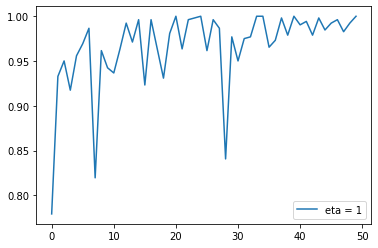

In [32]:
etas = [.001, .01, 0.1, 1]

for eta in etas:
    np.random.seed(42)  # Reset randomness
    # Workspace 2.7
    # BEGIN 
    m = LogisticRegression(eta)
    plt.plot(m.fit(binary_digits.X_train, binary_digits.y_train, epochs=50, batch_size=1), label="eta = " + str(eta))
    plt.legend()
    plt.show()
    # END


**Q2.8[3pts]** Plot the recall trend for the different values of eta on the test data.
(reset random seed for each loop to mitigate the randomness effect)

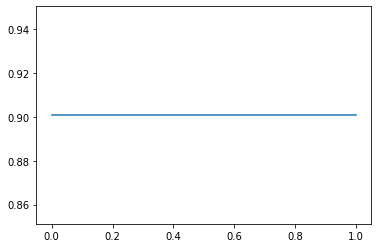

In [33]:
etas = [.0001, .001, .01, 1]
recal = []
for eta in etas:
    np.random.seed(42)
    # Workspace 2.8
    m = LogisticRegression(eta)
    m.fit(binary_digits.X_train, binary_digits.y_train, epochs=50, batch_size=1)
    y_pred = m.predict(binary_digits.X_test)
    _recal = recall_score(binary_digits.y_test, y_pred)
    recal.append(_recal)

#xaxis label is eta, yaxis label is recall
plt.plot(etas, recal)
plt.show()


    

This time we want to analyze the effect of varying the batch size. We fix `eta=0.01` and `epochs=50` and we want to
examine the recall on the test set at the end of the training.

**Q2.9[5pts]** Produce a plot of the recall on the test data at the end of the training as a function of the batch size. Reset the random generator for each iteration.

Use batch sizes provided below

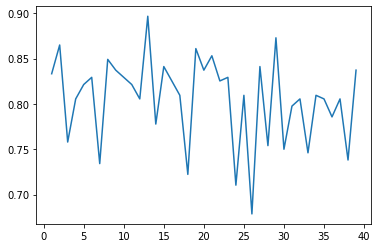

In [34]:
batch_sizes = list(range(1, 40))
recalls = []

for b_size in batch_sizes:
    np.random.seed(4622)
    # Workspace 2.8
    # BEGIN 
    m = LogisticRegression(0.01)
    m.fit(binary_digits.X_train, binary_digits.y_train, epochs=50, batch_size=b_size)

    y_pred = m.predict(binary_digits.X_test)
    recal = recall_score(binary_digits.y_test, y_pred)
    recalls.append(recal)
    # END


**Q2.10[Bonus 8 pts]** Since we're done with the binary regression, we will try to add Ridge regularization:
\begin{align}
\textrm{NLL}(w) = -\frac{1}{N}\sum_{i=1}^N \left[y_i \log \sigma(\mathbf{w}^T{x_i}) + (1-y_i)\log(1 - \sigma(\mathbf{w}^Tx_i))\right] + \alpha {||\mathbf{w}||^2}_{\geq1}
\end{align}

This is exactly what we will be using the `alpha` parameter in `LogisticRegression` for.
First, write the gradient formula in the cell below and edit your `compute_gradient` to account for the regularization term. Note that the regularization $||w||^2$ does not apply to the intercept $\mathbf{w}_0$

% BEGIN

% YOUR ANSWER HERE

% END

# Problem 3: Q-Learning (30 points + 10)

In [1]:
import numpy as np
import data
import helpers
import tqdm.notebook
import matplotlib.pyplot as plt

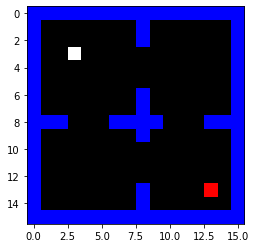

In [2]:
environment = data.GRID(grid_size=16, max_time=2000)
environment.reset()
environment.render()


We'll be using a _4-rooms_ environment where the goal of the agent (white square) is to reach the target (red square).
The grid is 16 by 16, so there are 256 states. Not all the states are accessible, since the agent can't cross the blue walls.
Each state $s$ is represented as a tuple $(x_s, y_s)$ that reflects the position of the agent.

There are 4 possible actions at each state (clockwise): Up (0), Right(1), Down(2), Left(3).
The agent gets a penalty (reward = -1) if it hits the blue walls and a reward = 1 if it reaches the target.
The episode ends (game over) when the target is reached or the agent has taken 2000 steps.

We will be using Q-learning to find a good policy that will allow us to reach the target before the time runs out.

At step $t$, the agent is located at state $s_t$ and chooses an action $a_t = \pi(s_t)$ following the policy $\pi$

The agent then gets reward $r_t$ and moves to state $s_{t+1}$. The process repeats until we reach a final state $s_T$ (`game_over == True`)

We'll call a replay a sequence of tuples $(s_t, a_t, r_t, s_{t+1})$.

Initial state:(3, 3)
Took action: Down
New state: (4, 3)
Reward: 0
Game over:False


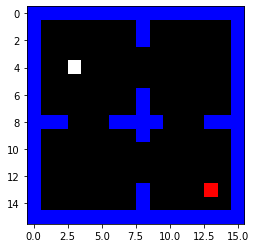

In [3]:
# How to create a replay with one element
# repeat as long as game_over is false
replay = []
current_state = environment.reset()
action = 2
print("Initial state:{}".format(current_state))
new_state, reward, game_over = environment.step(action)  # down
replay.append((current_state, action, reward, new_state))
current_state = new_state
print("Took action: {}".format(data.grid.ACTIONS_NAMES[action]))
print("New state: {}\nReward: {}\nGame over:{}".format(new_state, reward, game_over))
environment.render()

Starting at time $t=0$, The agent's goal is to maximize the expected discounted rewards:
\begin{align}
\eta_\pi = \sum_{t | a_t =\pi(s_t)} \gamma^t r_t
\end{align}
$0<\gamma<1$ is the discount rate. We'll be using $\gamma = 0.95$

$Q_\pi(s_t, a_t)$ is defined as the expected discounted rewards if we start at state $s_t$, take an initial actions $a_t$, and
follow the policy $\pi$ to decide the remaining action $(a_{t+1},..... a_{T-1})$.

\begin{align}
Q_\pi(s,a) = \eta_\pi, \text{ such that } s_0 = s \text{ and } a_0 = a
\end{align}

Since at each instant $t$, we want to pick the action that yields the best expected rewards, the optimal policy $\pi^*$ would be:
\begin{align}
\pi^*(s) = \arg\max_a Q^*(s, a)
\end{align}

__So how do we learn the optimal $Q^*$?__

By exploring the environment and saving a replay $\text{Replay} = \{(s_t, a_t, r_t, s_{t+1})| t\leq T\}$ (one that reaches the goal, hopefully),

we can use _Bellman equations_ to update our estimate of the $Q$ function in the following way:
\begin{align}
Q_{new}(s_t, a_t) \leftarrow r_t + \gamma \max_a Q_{old}(s_{t+1}, a), \;\;\; \forall \; (s_t, a_t, r_t, s_{t+1})\in \text{Replay}
\end{align}

We can prove that repeating this update will make our estimate converge to a unique optimal state-action value function $Q^*$.

Instead of "brutally" updating Q, we'll use a learning rate $\alpha$, so that the update would be :
\begin{align}
Q_{new}(s_t, a_t) \leftarrow  (1-\alpha)Q_{old}(s_t, a_t) + \alpha\big[r_t + \gamma \max_a Q_{old}(s_{t+1}, a) \big]
\end{align}

In this first part, we'll use an array `Q` of shape (16 x 16 x 4) to store $Q$, and the value $Q(s,a)$ would be accessed via `Q[x_s, y_s, a]`.

**Q3.1[6pts]** Complete the class method `TabularQ.update` to apply _Bellman_ updates provided a replay


In [4]:
class TabularQ:
    def __init__(self, gamma=0.95, learning_rate=0.01):
        self.Q = np.zeros((16, 16, 4))
        self.gamma = gamma
        self.alpha = learning_rate

    def update(self, replay):
        for s_t, a_t, r_t, s_t_p_1 in replay:
            # Workspace 3.1
            # BEGIN 
            self.Q[s_t[0], s_t[1], a_t] = self.Q[s_t[0], s_t[1], a_t] + self.alpha * (r_t + self.gamma * np.max(self.Q[s_t_p_1[0], s_t_p_1[1], :]) - self.Q[s_t[0], s_t[1], a_t])
            # END

    def best_action(self, s):
        action = np.argmax(self.Q[s[0], s[1]])
        return action

    def save(self, checkpoint_name):
        np.savez_compressed(checkpoint_name, Q=self.Q)

    def load(self, checkpoint_name):
        self.Q = np.load(checkpoint_name +".npz" )["Q"]


Now we have to address a different question: when we explore the environment, how should we choose the actions?

One approach is to follow a $\epsilon$-greedy policy, where we choose a random action with probability $\epsilon$ and the best action according to Q with probability $1-\epsilon$.

For instance, if $\epsilon=1$, all actions are chosen randomly. For $\epsilon=0$, all actions are chosen _greedily_.
A common practice is to start with $\epsilon=1$ and decay it to 0 as we generate replays. How fast we decay it is related to the famous _exploration-exploitation_ dilemma in Reinforcement Learning.

**Q3.2[6pts]** Complete `EpsilonGreedy.act` to return a uniformly random action with probability $\epsilon$ and the best action with probability $1-\epsilon$




In [5]:
class EpsilonGreedy():

    def __init__(self, Q, epsilon=1):
        self.Q = Q
        self.epsilon = epsilon

    def act(self, state):
        action = None
        # Workspace 3.2
        # BEGIN 
        if np.random.random() < self.epsilon:
            action = np.random.randint(0, 4)
        else:
            action = self.Q.best_action(state)
        # END


**Q3.3[6pts]** Complete the cell below to generate a replay from one episode (until the game is over)


In [6]:
def play(environment, policy):
    # Returns one episode's replay and the total accumulated rewards
    replay = []
    current_state = environment.reset()
    game_over = False
    total_rewards = 0
    while not game_over:
        # Workspace 3.3
        # BEGIN 
        action = policy.act(current_state)
        new_state, reward, game_over = environment.step(action)
        replay.append((current_state, action, reward, new_state))
        current_state = new_state
        total_rewards += reward
        
        # END
    return replay, total_rewards

**Q3.4[6pts]** Complete the cell below to generate replays and update `tabular_Q` for `n_episodes`. You're free to choose your own decaying rate for $epsilon$ (including a 0 decay)

In [7]:
tabular_Q = TabularQ()
n_episodes = 20
greedy_policy = EpsilonGreedy(tabular_Q, epsilon=1.0)
decay = 0.995

for _ in range(n_episodes):
    # Workspace 3.4
    # BEGIN 
    replay, total_rewards = play(environment, greedy_policy) 
    tabular_Q.update(replay)
    greedy_policy.epsilon *= decay
    
    # END

Now let's examine how the agent behaves a following random policy vs our Q-learning policy.

You should notice that if you run Q-learning multiple times, you might get different policies (different ways to reach the target) : we've mentioned before that $Q^*$ is unique, it's not the case for $\pi^*$

In [9]:
_ = play(environment, EpsilonGreedy(tabular_Q, epsilon=1.0)) # completely random policy
helpers.save_frames(environment.episode, target_mp4="uniform") # saves the episode to uniform.mp4
helpers.display_video("uniform") # display uniform.mp4

ValueError: Could not find a backend to open `uniform.mp4`` with iomode `wI`.
Based on the extension, the following plugins might add capable backends:
  FFMPEG:  pip install imageio[ffmpeg]
  pyav:  pip install imageio[pyav]

_Hint_ : if trained properly, you should expect "Best policy reached target after" < 30 steps

In [10]:
episode_length = len(play(environment, EpsilonGreedy(tabular_Q, epsilon=0.0))[0]) # optimal policy
helpers.save_frames(environment.episode, target_mp4="best_tabular")
helpers.display_video("best_tabular") # best_tabular.mp4
print("Best policy reached target after {} steps".format(episode_length))

ValueError: Could not find a backend to open `best_tabular.mp4`` with iomode `wI`.
Based on the extension, the following plugins might add capable backends:
  FFMPEG:  pip install imageio[ffmpeg]
  pyav:  pip install imageio[pyav]

**Q3.5[6pts]** To get the full credit of the previous questions, you'll have to submit a zip file `q_learning.zip` that includes `uniform.mp4`, `best_tabular.mp4` from previous cells and `best_tabular.npz` from the cell below

_Hint_:  If cells ran correctly, the files should appear in the same path as the notebook

In [ ]:
tabular_Q.save("best_tabular")


## Bonus: Deep Q Learning
What made the tabular Q-learning more approachable is our knowledge of the state space. Our grid is 16 by 16, so there are 256 states in total (not all of them are accessible, due to the environment restrictions.)

In the next Deep Q-learning section, we add randomness to our environment. In our _random_ grid, the target and the agents are randomly located, that yields $256^2 = 65536$ states. Not outside the realm of a tabular Q, but we will try to avoid that.

When the grid is _random_, the state is no longer the (x,y) coordinates, but a 16x16 image of the environment


In [ ]:
random_environment = data.GRID(grid_size=16, random=True, max_time=200)
s = random_environment.reset()
print(s.shape, s.max(), s.min())
plt.imshow(s)

In Deep Q learning, we model Q as neural network $Q_\theta$ where $\theta$ represent the network parameters.
The neural network takes the state image as input and outputs a 4-dimensional array $Q(s)$ where $Q(s)_i = Q(s, i) $ for $i\in[0,1,2,3]$.

Given a replay $Replay$, we will call an iteration:
- Get the current $Q$ values of the states $s_t$ : `Q_s`
- Get the current $Q$ values of the states $s_{t+1}$: `Q_s_p`
- Updates the element of `Q_s` following __Bellman__ method (you'll have to use `Q_s_p`, the replay actions and the rewards)
- Fit the neural network using the replays states and the computed `Q_s` for a single epoch

A single update might consist of several iterations ( do not confuse this with the neural network fit's epoch)

We'll be minimizing the objective
\begin{align}
    \mathcal{L}_\theta(\text{Replay}) = \sum_{(s_t, a_t, r_t, s_{t+1}) \in \text{Replay}} \mathcal{L}\big(Q_{\theta}(s_t, a_t) - \big[r_t + \gamma \max_a Q_\theta(s_{t+1}, a) \big] \big)
\end{align}
where $\mathcal{L}$ is a loss function.

In our implementation, we'll be using `Huber` loss. You're free to change the loss, the learning rate, and the network architecture. The ones provided bellow have been tested, and they're guaranteed to work

**Q3.6[8pts]** Complete `DeepQ.update` to perform _Bellman_ iterations

In [ ]:
from keras import models
from keras import layers
from keras import optimizers
from keras import losses

class DeepQ:
    def __init__(self, gamma=0.95):
        self.neural_net = models.Sequential([layers.InputLayer(input_shape=(16, 16, 3)),
                                             data.get_inception_layer(32, 32, 32),
                                             layers.Conv2D(64, 2, 2, activation="relu"),
                                             data.get_inception_layer(32, 32, 32),
                                             layers.Conv2D(128, 2, 2, activation="relu"),
                                             layers.Conv2D(256, 2, 2, activation="relu"),
                                             layers.Flatten(),
                                             layers.Dense(256, activation="tanh"),
                                             layers.Dense(512),
                                             layers.Dense(4)])  # Do not change the model
        optimizer = optimizers.adam_v2.Adam(learning_rate=1e-4)  # You can change the learning rate
        self.neural_net.compile(loss=losses.Huber(), optimizer=optimizer)  # You can also change the loss function
        self.neural_net.summary()
        self.gamma = gamma

    def update(self, replay, iterations=2, batch_size=32):
        current_states = np.array([r[0] for r in replay])
        actions = np.array([r[1] for r in replay])
        rewards = np.array([r[2] for r in replay])
        next_states = np.array([r[3] for r in replay])

        loss = 0
        for _ in range(iterations):
            # Workspace 3.6
            # Todo: predict Q_s and Q_s_p
            # Use Q_s_p, actions, rewards to update Q_s and fit self.neural_network for one epoch
            # Q_s = None
            
            # BEGIN 
            # code here
            # END
            history = self.neural_net.fit(current_states, Q_s, epochs=1, batch_size=batch_size)
            loss += history.history["loss"][0]
        print("Loss:", loss / iterations)

    def best_action(self, s):
        # We want to allow some noise in the estimation
        q = self.neural_net.predict(s[None, :])[0]
        q_max = np.max(q)
        possible_actions = np.where(np.abs(q - q_max) < 0.05 * np.std(q))[0]
        return np.random.choice(possible_actions)

    def checkpoint(self, checkpoint_path):
        self.neural_net.save_weights(checkpoint_path)

    def load(self, checkpoint_path):
        self.neural_net.load_weights(checkpoint_path)


In [ ]:
deep_Q = DeepQ()

Feel free to tweak the training parameters if you think it would improve learning. The provided ones have been tested and they should work.

In [ ]:
greedy_policy = EpsilonGreedy(deep_Q, epsilon=1.0)
# Tweak the next parameters to improve the learning
n_episodes = 80
steps_per_replay = 8000
decay= 0.995

In [ ]:
for e in range(n_episodes):
    replay = []
    episode = []
    rewards = 0
    pbar = tqdm.notebook.tqdm(desc="Generating replay", total=steps_per_replay)
    while len(replay) < steps_per_replay:
        rep, rew = play(random_environment, greedy_policy)
        episode += random_environment.episode
        replay += rep
        rewards += rew
        pbar.update(len(rep))
    pbar.close()
    helpers.save_frames(episode, "currently_training") # save video of last episodes played

    print("episode", e + 1,"/",n_episodes,", eps:", greedy_policy.epsilon, "total rewards:", rewards)
    deep_Q.update(replay, iterations=4)
    greedy_policy.epsilon *= decay

**Q3.7[2pts]** To be considered for full credit, include `deep_q.mp4` and the `checkpoint` folder in your submitted `q_learning.zip`

_Hint_ : if trained properly, you should expect `"Total rewards over 10 episodes` > 75

In [ ]:
short_random_environment = data.GRID(random=True, max_time=100)
episodes = []
deep_best_policy = EpsilonGreedy(deep_Q, epsilon=0)
rewards = 0
for _ in tqdm.notebook.tqdm(range(10)):
    rewards += play(short_random_environment, deep_best_policy)[1]
    episodes += short_random_environment.episode
print("Total rewards over 10 episodes:", rewards)
helpers.save_frames(episodes, "deep_q")

In [ ]:
helpers.display_video("deep_q")

In [ ]:
deep_Q.checkpoint("checkpoint/deep_q")